In [1]:
!pip install tensorflow
!pip install tensorflow_datasets
!pip install transformers
!pip install tf-keras
!pip install shap
!pip install nltk

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizerFast
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

2025-06-26 20:43:44.200810: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-26 20:43:44.205806: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-26 20:43:44.218381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750970624.239913    1292 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750970624.246149    1292 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750970624.262769    1292 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# Load the saved model
model_path = './sentiment_model_distilbert'
model = TFDistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Load test dataset (same preprocessing as training)
(_, ds_test), ds_info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

2025-06-26 20:43:49.799245: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at ./sentiment_model_distilbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [4]:
# Define the lists of influential words to remove
positive_words_to_remove = [
    'often', 'pathetic', 'afoot', 'camera', 'criticizing', 
    'double-entendres', 'globalpublicmedia.com', 'video', 'lost', 'lead'
]

negative_words_to_remove = [
    'surprising', 'release', 'sesame', 'ever', 'enjoy.<br', 
    'ploy', 'liked', 'ludicrously', 'street"....hoo', 'horrible'
]

# Combine into a single set for efficient removal
words_to_remove = set(positive_words_to_remove + negative_words_to_remove)

# Function to clean the text by removing specified words
def remove_influential_words(text):
    """
    Removes a predefined list of influential words from the input text.
    """
    words = text.split()
    # Rebuild the text, excluding the words in our removal set
    cleaned_words = [word for word in words if word.lower().strip('.,!?":;()[]{}') not in words_to_remove]
    return ' '.join(cleaned_words)

# Tokenization functions to include the cleaning step
def encode(text, label):
    text_str = text.numpy().decode('utf-8')
    
    # --- NEW STEP: Clean the text before tokenizing ---
    cleaned_text = remove_influential_words(text_str)
    
    tokens = tokenizer(
        cleaned_text,  # Use the cleaned text
        truncation=True,
        padding='max_length',
        max_length=256
    )
    return tokens['input_ids'], tokens['attention_mask'], label

def tf_encode(text, label):
    input_ids, attention_mask, label = tf.py_function(
        encode, [text, label], [tf.int32, tf.int32, tf.int64]
    )
    input_ids.set_shape([256])
    attention_mask.set_shape([256])
    label.set_shape([])
    return {"input_ids": input_ids, "attention_mask": attention_mask}, label

In [5]:
# Prepare test dataset
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16
ds_test_processed = ds_test.map(tf_encode, num_parallel_calls=AUTOTUNE)
ds_test_processed = ds_test_processed.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Compile model for evaluation
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [6]:
# 1. Basic model evaluation
test_loss, test_accuracy = model.evaluate(ds_test_processed, verbose=1)
print(f"\nBasic Evaluation Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 2. Get predictions and true labels for detailed metrics
print("\nGenerating predictions for detailed metrics...")
y_true = []
y_pred_logits = []

for batch_x, batch_y in ds_test_processed:
    predictions = model(batch_x, training=False)
    y_pred_logits.extend(predictions.logits.numpy())
    y_true.extend(batch_y.numpy())

y_true = np.array(y_true)
y_pred_logits = np.array(y_pred_logits)

# Convert logits to probabilities and predictions
y_pred_proba = tf.nn.softmax(y_pred_logits, axis=1).numpy()
y_pred = np.argmax(y_pred_logits, axis=1)

# 3. Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

# 4. Confusion Matrix
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Calculate additional metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"\nDetailed Metrics:")
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")

# 5. ROC-AUC Score
roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")

2025-06-26 20:43:57.757258: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


1563/1563 [==============================] - 3478s 2s/step - loss: 0.2444 - accuracy: 0.9076

Basic Evaluation Results:
Test Loss: 0.2444
Test Accuracy: 0.9076

Generating predictions for detailed metrics...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative       0.92      0.89      0.91     12500
    Positive       0.89      0.92      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000


CONFUSION MATRIX
[[11144  1356]
 [  953 11547]]

Detailed Metrics:
True Positives: 11547
True Negatives: 11144
False Positives: 1356
False Negatives: 953
Precision: 0.8949
Recall (Sensitivity): 0.9238
Specificity: 0.8915
F1-Score: 0.9091
ROC-AUC Score: 0.9690


2025-06-26 22:51:52.571247: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


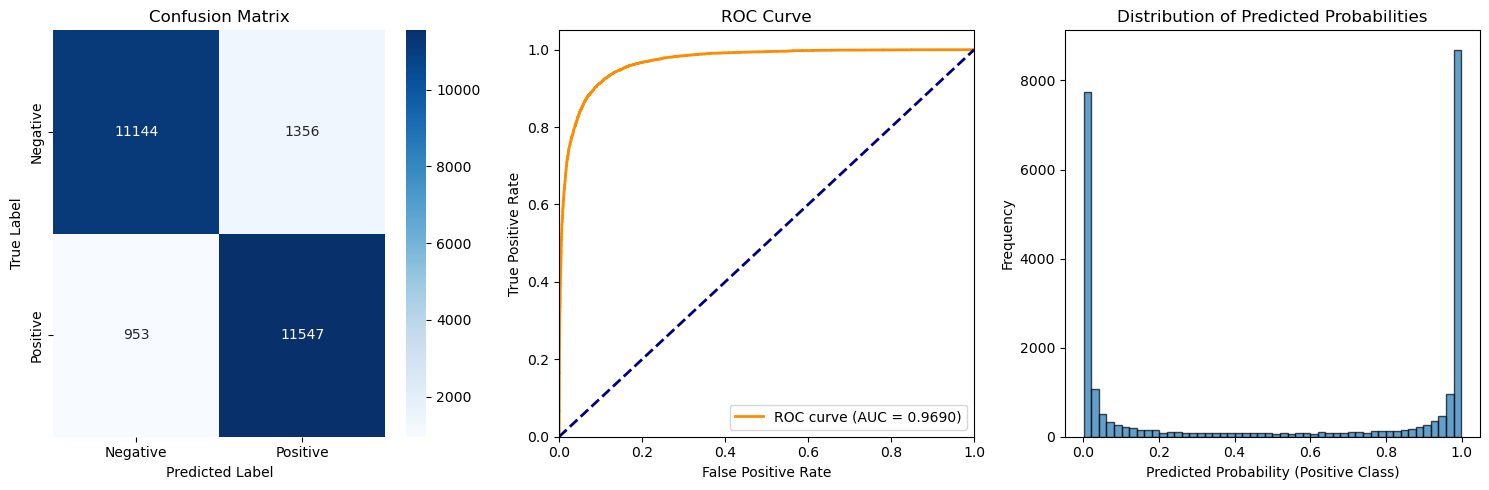


SAMPLE PREDICTIONS WITH CONFIDENCE

Sample 1:
Text: Never has the words "hidden gem" been so accurate. Bad movie lovers might search all over for the next hidden obscurity, sometimes coming up short with stuff like Weasels rip my flesh, but other times...
True Label: Positive
Predicted Label: Positive
Confidence: 0.9849
Correct: ✓
--------------------------------------------------

Sample 2:
Text: First off, I have been a fan of the show back when my PBS station started showing it back in 1981. I learned many things about the show and the people who were in or contributed to the show.<br /><br ...
True Label: Positive
Predicted Label: Positive
Confidence: 0.8474
Correct: ✓
--------------------------------------------------

Sample 3:
Text: I've been watching Attack Of The Show religiously for about 6 months (maybe longer but not much). I was very infatuated with Olivia and I found Kevin to be very witty and the repertoire between them v...
True Label: Positive
Predicted Label: Negativ

In [7]:
# 6. Visualizations
plt.figure(figsize=(15, 5))

# Confusion Matrix Heatmap
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Prediction Distribution
plt.subplot(1, 3, 3)
plt.hist(y_pred_proba[:, 1], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Predicted Probability (Positive Class)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')

plt.tight_layout()
plt.savefig('model_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. Sample predictions with confidence
print("\n" + "="*50)
print("SAMPLE PREDICTIONS WITH CONFIDENCE")
print("="*50)

# Get some sample texts and their predictions
sample_indices = np.random.choice(len(y_true), 5, replace=False)
sample_texts = []

# We need to get the original texts, so let's process a few samples
count = 0
for text, label in ds_test.take(len(y_true)):
    if count in sample_indices:
        sample_texts.append((text.numpy().decode('utf-8'), label.numpy()))
    count += 1
    if len(sample_texts) == 5:
        break

for i, (text, true_label) in enumerate(sample_texts):
    idx = sample_indices[i]
    pred_label = y_pred[idx]
    confidence = max(y_pred_proba[idx])
    
    print(f"\nSample {i+1}:")
    print(f"Text: {text[:200]}...")
    print(f"True Label: {'Positive' if true_label == 1 else 'Negative'}")
    print(f"Predicted Label: {'Positive' if pred_label == 1 else 'Negative'}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Correct: {'✓' if pred_label == true_label else '✗'}")
    print("-" * 50)

In [8]:
# 8. Summary
print("\n" + "="*50)
print("EVALUATION SUMMARY")
print("="*50)
print(f"Overall Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Total Test Samples: {len(y_true)}")


EVALUATION SUMMARY
Overall Accuracy: 0.9076
Precision: 0.8949
Recall: 0.9238
F1-Score: 0.9091
ROC-AUC: 0.9690
Total Test Samples: 25000
